# Computational Essay: Quantum Dot Charge Qubits in Semiconductors

**Samuel Shelton z5359712**

**Begin Preamble / Marking Notes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy import constants
from matplotlib.animation import FuncAnimation
from IPython import display
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from scipy import sparse
from scipy import special

from datetime import datetime
print('This cell last executed at: ', datetime.now())

This cell last executed at:  2023-04-24 01:44:57.237844


I have - quite painstakingly - animated a lot of the graphs in this report. These are lost if you just view the PDF, and the animations are stored and displayed in HTML (so if you view the notebook in, say, PyCharm they may be lost).

You can access the file for this on [GitHub](https://github.com/Sam-js2/PHYS3112_CompEssay/blob/055834c5c388a23c56dbb4f2bf98cd3abbc5fa83/z5359712_Computational%20Essay.ipynb), although animations won't work on the web browser (tested in WebKit and Chromium).

In order to make everything work for you, please run this Notebook using an Anaconda Kernal in Jupyter Lab/Notebook and install [FFmpeg](https://ffmpeg.org/). You might already have FFmpeg installed, but if not, the following commands should help.

Some guidance on some possible bugs is [here](https://www.tutorialspoint.com/how-to-properly-enable-ffmpeg-for-matplotlib-animation), but for me it was just one console command on both macOS and windows. IPython is also required, although you *should* already have this. If not, Conda install IPython.

At multiple points I suggest playing with the cells. This only works if you rerun all cells in order first, and some of them take quite a while. If you have a less beefy PC than me (or just any laptop at all), I recommend turning down the number of nodes and timesteps. You can safely halve them (or even chop of a factor of 10). 'Timesteps' for animations are typically controlled by a 'frames' or 'repeats' variable, which should be defined close to the nodes variable.

{defining a LaTeX command for bra/ket notation - ignore any errors you see}

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Please note that some variables are defined early and persist across multiple cells. This allows for changes to carry over easily. Check the preamble in some cells for some 'var_1 = var_1,' this is there for you to change if you want to. 

I ran this last on a quite powerful computer, so again, be warned. Many cells take on the order of two minutes to run, a few significantly longer. The entire notebook took my Quad Core / 16 gb Ram desktop just over 10 minutes to run.

# [**Link to Github to get Actual Notebook Files**](https://github.com/Sam-js2/PHYS3112_CompEssay)

**End Preamble / Marking Notes**

## Introduction & Background

Qubits are the quantum computing equivalent of a classical bit. Instead of existing in two states ('on' and 'off' - or 'high' and 'low'), they exist as a superposition of two states ($a \ket{1} + b \ket{0}$). Instead of a switch being either on or off, the Qubit will be in a superposition - essentially both at once.

The fundamental equation for solving these problems is a modified form of the Schrodinger's Equation.

$$
- \frac{\hbar^2}{2 m} \frac{d^2 \psi(x)}{dx^2} + V(x) \psi (x) = E \psi(x)
$$

At UNSW, the focus of research is on Quantum computing in silicon (what goes on in the Newton Building), and that is what this report focuses on. In a silicon Quantum computer, qubits are manufactured using traditional semiconductor manufacturing techniques (photolithography) on dopped silicon wafers (like non-quantum computer microchips). Instead of using mass $m$, we use an effective mass $m^*$ to reflect the behaviour of an electron within the semiconductor material. For an electron in Silicon, we approximate $m^* = 0.2 \times m$.

### Quantum Dots

A Quantum Dot (in the context of Quantum Computing) is a point charge (electron, but you could use something else) trapped in three dimensions by an electrostatic potential (applied, in this case, by a gate with current running through it above the silicon oxide surface) in a Silicon ($^{28}\text{Si}$) lattice, below an insulating, oxidised surface (an $\text{SiO}_2$ layer).

![A Single Quantum Dot Example](https://github.com/Sam-js2/PHYS3112_CompEssay/blob/main/single_QD.png?raw=true)

>   A Single QD, this Diagram is taken from the task description

In reality, an implementation of a QD like that above looks something like this:

![Example from Nature](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnature15263/MediaObjects/41586_2015_Article_BFnature15263_Fig1_HTML.jpg?as=webp)

>   A Real Implementation of a (spin) QD, from Veldhorst, M., Yang, C., Hwang, J. et al

You can see the gates highlighted, but the single electron is buried below the surface of the silicon. There is a small channel with current passing through it to induce a magnetic field that interacts with the electronic spins, because this is a spin qubit. Most research is done on *spin* qubits, where the electrons are still trapped in a parabolic potential, but it is the measurement of their spin which gives us the two states (i.e., spin up or down). In this assignment, we are using a *charge* qubit, where the localisation of the electron within an applied magnetic field gives us our two states (i.e., is the electron localised in the left or right parabolic potential?). 

**In this report, we will:**

1) Investigate the Generalised two-level Quantum System

2) Construct a toy system with a single parabolic potential, controlling the energy gap between the ground and first excited states with the potential strength

3) Evolve this toy system into a double Quantum dot, watch how the system behaves with different dot-to-dot separations

4) Apply a fixed magnetic field $V(x) = F x$ and watch how the system behaves across various values of $F$

5) Replace this with a time-dependant magnetic field (Rabi Oscillations), and watch how the system behaves and how qubit readouts would behave

6) Investigate the behaviour of a system similar to 4) in three (two spatial, one potential) dimensions

### Part A) Formalism of the Generalised two-level System

A general two-level system is a Quantum system that exists as a superposition of two independent - but, crucially, observable / physically distinguishable - states. Examples of a two-level system include Electron Spin in the Stern-Gerlach experiment, and (as we will investigate) Quantum Dots. A generalised, two-level system can be described by the following Hamiltonian:

$$
H = \begin{bmatrix}
E & t \\
t^* & -E 
\end{bmatrix}
$$

This can be trivially derived from a linear combination of the Pauli spin matrices. By inspection, this Matrix is Hermitian, which is as we should expect if it is to correspond to any kind of physical observable. There are multiple ways to reformulate this Hamiltonian with slightly different variables (as you might recall from some Quantum courses), but they all behave equivalently.

We seek an analytic solution to this Hamiltonian. We will first determine the eigenvalues by solving the characteristic equation as follows:

$$
\left|
\begin{bmatrix}
E - \lambda & t \\
t^* & -E - \lambda
\end{bmatrix}
\right| = 0 
$$
$$
\left( E - \lambda \right) \left( -E - \lambda \right)  - t t^* = 0
$$
$$
E^2 - \lambda^2 + \left| t \right|^2 = 0
$$
$$
\therefore \lambda_1 = \sqrt{E^2 + \left| t \right|^2}, \qquad \lambda_2 = -\sqrt{E^2 + \left| t \right|^2}
$$

For continuity with the question we define $\lambda_1 = E_1$ and $\lambda_2 = E_2$.

We can then plug these back into the definition of Eigenvectors/Values to find the corresponding eigenvectors:

$$
A v = \lambda v, \qquad \therefore \left( A - \lambda \right) v = 0
$$

For $\lambda_1$:

$$
 \left( A - I \lambda_1 \right) v_1 =
\begin{bmatrix}
E - \lambda_1 & t \\
t^* & -E - \lambda_1
\end{bmatrix} \begin{bmatrix}
a \\
b
\end{bmatrix} = \begin{bmatrix}
0 \\
0
\end{bmatrix}
$$
$$
\begin{bmatrix}
E -  \sqrt{E^2 + \left| t \right|^2} & t \\
t^* & -E - \sqrt{E^2 + \left| t \right|^2}
\end{bmatrix} \begin{bmatrix}
a \\
b
\end{bmatrix} = \begin{bmatrix}
0 \\
0
\end{bmatrix}
$$

There are a couple of different ways to solve this equation, but we will break it up into two simultaneous equations and solve for $a$ and $b$ to find $v_1$.

$$
\left( E -  \sqrt{E^2 + \left| t \right|^2} \right) a + b t = 0, \qquad a t^* + \left( - E -  \sqrt{E^2 + \left| t \right|^2} \right) b = 0
$$

From the left and right respectively, we derive the following expressions:
$$
a = \frac{bt}{\sqrt{E^2 + \left| t \right|^2} - E}, \qquad b = \frac{a t^*}{\sqrt{E^2 + \left| t \right|^2} + E}
$$

Substituting our expression for $a$ into our expression for $b$:

$$
b = \frac{\left( \frac{bt}{\sqrt{E^2 + \left| t \right|^2} - E} \right) t^*}{\sqrt{E^2 + \left| t \right|^2} + E} = b \implies b \text{ is independant of variables} \qquad \therefore \text{Set } b = 1
$$

And substituting $b = 1$ into $a$ yields:

$$
a = \frac{t}{\sqrt{E^2 + \left| t \right|^2} - E}
$$

So, therefore, we have:

$$ \lambda_1 = E_1 = \sqrt{E^2 + \left| t \right|^2}, \qquad v_1 = \begin{bmatrix}
\frac{t}{\sqrt{E^2 + \left| t \right|^2} - E} \\
1
\end{bmatrix} = \frac{t}{\sqrt{E^2 + \left| t \right|^2} - E} \ket{0} + \ket{1}
$$

Through the same method (or by applying symmetry and verifying using the definition of Eigenstuff), we can derive: 

$$ \lambda_2 = E_2 = - \sqrt{E^2 + \left| t \right|^2}, \qquad v_2 = \begin{bmatrix}
\frac{-t}{\sqrt{E^2 + \left| t \right|^2} + E} \\
1
\end{bmatrix} = \frac{-t}{\sqrt{E^2 + \left| t \right|^2} + E} \ket{0} + \ket{1}
$$

Our initial reaction might be to try normalise these coefficients ( i.e., such that for $\psi = a \ket{0} + b \ket{1}$, $1 = \sqrt{a^2 + b^2}$ ), but we won't do that here because it is much easier to this in the code and the analytic result does not nicely simplify.

This is a bit non-trivial, but as $t \rightarrow 0$,  $\ket{\psi_2} \rightarrow \ket{1}$, and vice versa for $\psi_2$. We will need to sanity check our probability results later.

Let’s plot the Eigenvalues as a function of $E$, with an evolving $t$. Here, we are using purely real $t$ for simplicity.

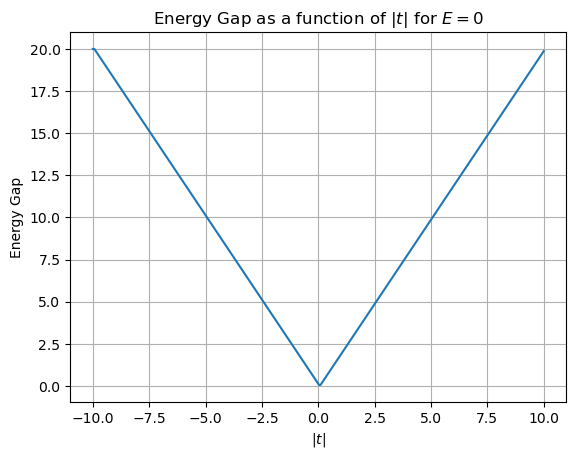

In [23]:
frames = 300

t_space = np.linspace(-10, 10, frames)
E_set = np.linspace(0,20,20)

gaps=[]

def animate(i):
    t = t_space[i]
    E_1 = np.sqrt( np.add( np.power(E_set, 2), np.power(np.absolute(t), 2) ) )
    E_2 = - np.sqrt( np.add( np.power(E_set, 2), np.power(np.absolute(t), 2) ) )
    gap = E_1[0] - E_2[0]; gaps.append(gap)
    E1_line.set_data(E_set, E_1)
    E2_line.set_data(E_set, E_2)
    t_text.set_text('$t =$ {}'.format(round(t,1)))
    
fig, axs = plt.subplots()
axs.grid()
axs.set_title('Eigenvalues as a function of $E$ with evolving $|t|$')
axs.set_xlabel('$E$')
plt.ylim(-20,20)
plt.xlim(0,20)
axs.set_ylabel('Energy Gap / E')
E1_line, = axs.plot([],[], label='$E_1$')
E2_line, = axs.plot([],[], label='$E_2$')
t_text = axs.text(12.6, 1, 'x')
axs.legend(loc=7)

anim = FuncAnimation(fig, animate, frames=frames, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

plt.title('Energy Gap as a function of $|t|$ for $E=0$')
plt.grid()
plt.xlabel('$|t|$')
plt.ylabel('Energy Gap')
plt.plot(t_space, gaps[:-1])
plt.show()

Now let’s plot the probability of measuring $E_1$ or $E_2$ at $\ket{1}$ or $\ket{2}$ as a function of $E$ (and we can evolve this with $t$).

In [3]:
frames = 250
E_list = np.linspace(-5,5,frames)
t_list = np.linspace(-5,5,frames)

def animate(i):
    t = t_list[i]
    E = E_list
    
    psi0 = t / ( np.sqrt(E**2 + np.abs(t)**2) - E )
    psi1 = 1
    
    p0 = psi0**2 / (psi1**2 + psi0**2)
    p1 = psi1**2 / (psi1**2 + psi0**2)
    
    psi10.set_data(E_list, p0)
    psi11.set_data(E_list, p1)
    
    psi0 = -t / ( np.sqrt(E**2 + np.abs(t)**2) + E )
    psi1 = 1
    
    p0 = psi0**2 / (psi1**2 + psi0**2)
    p1 = psi1**2 / (psi1**2 + psi0**2)
    
    psi20.set_data(E_list, p0)
    psi21.set_data(E_list, p1)
    
    plt.suptitle('$t$ = {}'.format(round(t,3)))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
t_text = fig.text(6,4, 'Hi')
    
psi10, = ax1.plot([],[], label='$p_0$')
psi11, = ax1.plot([],[], label='$p_1$')
psi20, = ax2.plot([],[], label='$p_0$')
psi21, = ax2.plot([],[], label='$p_1$')

ax1.set_xlim(-5,5)
ax1.set_ylim(0,1)
ax1.set_xlabel('E')
ax1.set_ylabel('Probability')
ax1.set_title('$\Psi_1$')
ax1.grid(); ax1.legend()

ax2.set_xlim(-5,5)
ax2.set_ylim(0,1)
ax2.set_xlabel('E')
ax2.set_ylabel('Probability')
ax2.set_title('$\Psi_2$')
ax2.grid(); ax2.legend()

plt.tight_layout()

anim = FuncAnimation(fig, animate, frames=frames, interval=50, blit=False)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

The graph you should see buried in that animation is a cosine squared graph. $t$ functions as an apparent dampening term which distorts this, but at an appropriate $t$ in relation to $E$ you would get just that. Note how the graph appears mirrored about the middle axis across $\Psi_1$ and $\Psi_2$.

Now, we want to try and build a toy system that mimics this formal behaviour, such that we can understand how one might go about constructing a Quantum Computing device. In order to do this, we will construct a simulated Quantum Dot using a basic parabolic potential.

## Results & Discussion

### Part B: The Single Quantum Dot

In the simplest model, we seek to solve the Schrodinger’s equation for $V(x) = \alpha (x - x_1)^2$. Here, $x_1$ is some offset (i.e., the 'zero point' off the potential), and for simplicity (and consistency across plots), we will set $x_1 = 0$.

This potential is a crude representation of a single charge QD, where the location of an electric charge (an electron) is controlled by applied electromagnetic fields. For just a single QD, there is only one ground state with one possible localisation, but we will see two possible, locally distinct eigenstates with the double quantum dot.

Because our potential is parabolic, so our immediate reaction should be to expect a solution that closely resembles that of the analytic solution to the time independent Schrodinger’s equation for the quantum harmonic oscillation.

#### **i)** First, let’s simply plot a solution to our potential

Energy Gap = 3.9976875027272016  meV


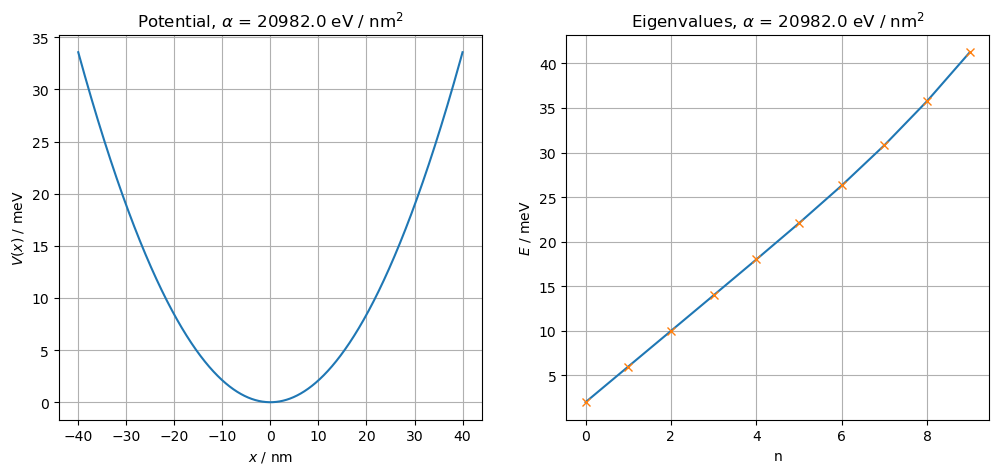

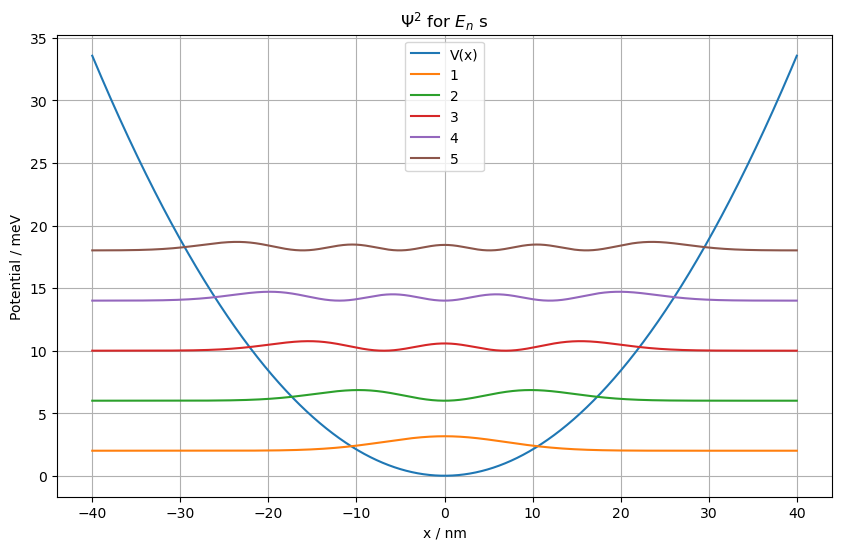

In [4]:
# Bounds and nodes for grid
plot_to = 40 # Bounds in nm
nodes = 4000
alpha = 20982.008208404975  # ev/nm^2

# Plot solutions to Psi over potential to check for issues, set to eigenvalue or 0 for nothing, recomend setting to at least 2
plot_check = 5

# Constants
q = 1.602E-19                   # Electron charge
hbar = 1.054E-34                # Reduced plancks constant
m = 0.2 * 9.109E-31             # Electron mass

Bounds = np.multiply(plot_to, [-1e-9, 1e-9])
X = np.linspace(*Bounds, nodes)
a = plot_to*2E-9/nodes

U = (alpha*1E9)*(X)**2

# Defining the Hamiltonian
t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

# Solving the Matrix
vals, vec = np.linalg.eigh(H)
idx = vals.argsort()[::1]   
vals = vals[idx]
vec = vec[:,idx]

#print eigenvalues and energy gaps
Energy_gap=vals[1]-vals[0]
print('Energy Gap =', Energy_gap*1E3,' meV')

# Make Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(X*1E9, U*1E3)
ax1.set_xlabel('$x$ / nm')
ax1.set_ylabel('$V (x)$ / meV')
ax1.set_title('Potential, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax1.grid()

ax2.plot(vals[:10]*1E3)
ax2.plot(vals[:10]*1E3, marker='x', linestyle='')
ax2.set_xlabel('n')
ax2.set_ylabel('$E$ / meV')
ax2.set_title('Eigenvalues, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax2.grid()

if plot_check != 0:
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(X*1E9, U*1E3, label='V(x)')
    for i in range(plot_check):
        plt.plot(X*1E9, (np.multiply(vec[:,i],vec[:,i]) + vals[i])*1E3, label='{}'.format(i+1))
    plt.grid()
    plt.ylabel('Potential / meV')
    plt.xlabel('x / nm')
    plt.legend()
    plt.title('$\Psi^2$ for $E_n$ s')
    plt.show()

This (predictably) looks exactly like our expected analytical solution! The Eigenvalue spacing is linear here (and quantised), exactly in line with the $\hbar \omega$ spacing in the analytical space. Also note the zero-point energy of the ground state.If you need a reminder, here is the Analytical probability density functions from Wikipedia:

![QHO From Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Aufenthaltswahrscheinlichkeit_harmonischer_Oszillator.png/440px-Aufenthaltswahrscheinlichkeit_harmonischer_Oszillator.png)

>	QHO Analytic Solution from Wikipedia

Let’s have a more detailed look at the two lowest wavefunctions:

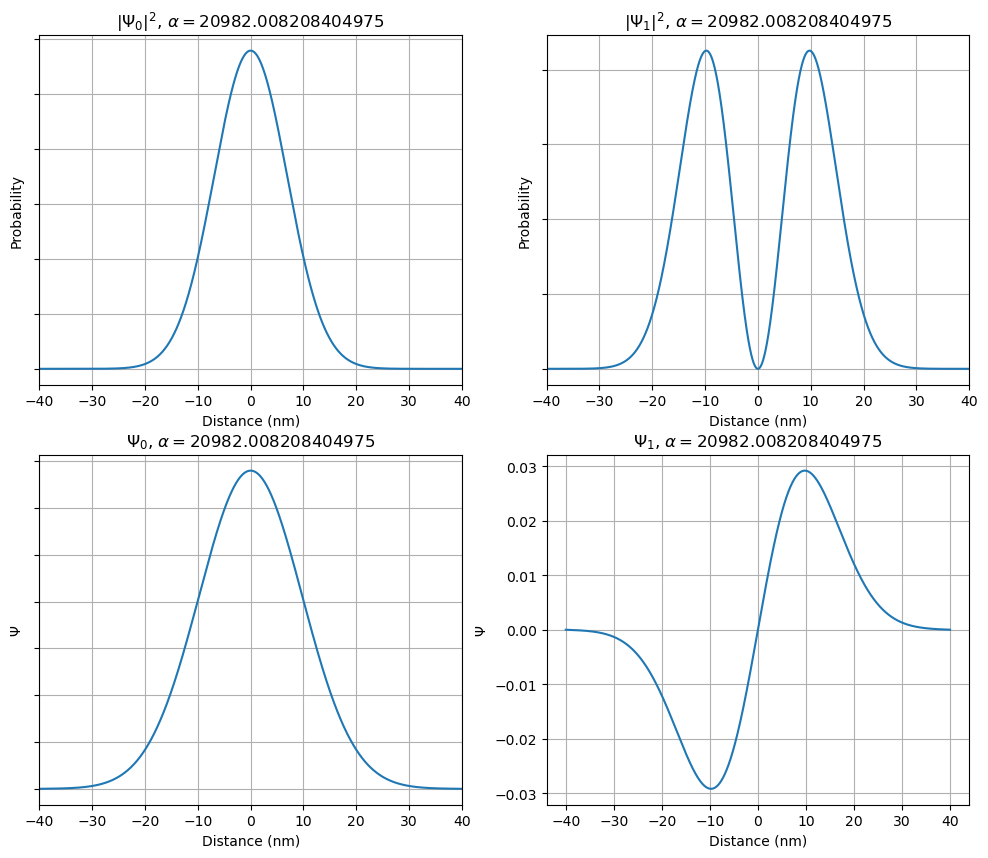

In [5]:
#calculate probabilities
Psi0=np.multiply(vec[:,0],vec[:,0])
Psi1=np.multiply(vec[:,1],vec[:,1])

# X lim for plotting
x_max = 40 #plot_to

# Make Plots
fig, axs = plt.subplots(2, 2, figsize=(12,10))
xlim = np.multiply(x_max, [-1, 1])

axs[0,0].plot(X*1E9, Psi0)
axs[0,0].set_xlabel('Distance (nm)')
axs[0,0].set_ylabel('Probability', )
axs[0,0].set_title('$|\Psi_0|^2$, $\\alpha = ${}'.format(alpha))
axs[0,0].grid(); axs[0,0].set_yticklabels([]), axs[0,0].set_xlim(*xlim)

axs[0,1].plot(X*1E9, Psi1)
axs[0,1].set_xlabel('Distance (nm)')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title('$|\Psi_1|^2$, $\\alpha = ${}'.format(alpha))
axs[0,1].grid(); axs[0,1].set_yticklabels([]), axs[0,1].set_xlim(*xlim)

axs[1,0].plot(X*1E9, vec[:,0])
axs[1,0].set_xlabel('Distance (nm)')
axs[1,0].set_ylabel('$\Psi$')
axs[1,0].set_title('$\Psi_0$, $\\alpha = ${}'.format(alpha))
axs[1,0].grid(); axs[1,0].set_yticklabels([]), axs[1,0].set_xlim(*xlim)

axs[1,1].plot(X*1E9, vec[:,1])
axs[1,1].set_xlabel('Distance (nm)')
axs[1,1].set_ylabel('$\Psi$')
axs[1,1].set_title('$\Psi_1$, $\\alpha = ${}'.format(alpha))
axs[1,1].grid(); #axs[1,1].set_yticklabels([]), axs[1,1].set_xlim(*xlim)

Again, very much as expected when compared to the analytic solution.

Let’s see how our energy gap varies as a function of $\alpha$, here we will explore a wide range of $\alpha$ using a logarithmic graph.

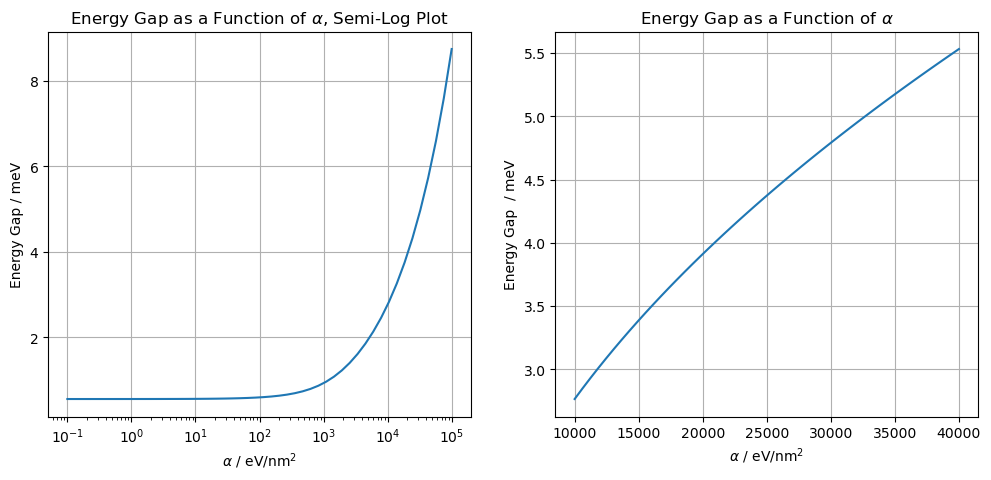

In [6]:
def space_from_alpha(alpha_range):
    
    # Parameters
    bounds = 50
    nodes = 400

    a = bounds*2E-9/nodes
    gap = []
    X=np.multiply(np.linspace(-bounds, bounds, nodes), 1E-9)  #nm

    t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
    on=2.0*t0*np.ones(nodes)
    off=-t0*np.ones(nodes-1)

    for al in alpha_range:
        
        U = al*1E9 * X**2
        H=np.diag(on+U)+np.diag(off,1)+np.diag(off,-1)

        W,V=np.linalg.eig(H)
        idx = W.argsort()[::1]   
        W = W[idx]
        V = V[:,idx]

        Energy_gap=W[1]-W[0]
        gap.append(Energy_gap)
    
    return gap

alpha_log_range = np.logspace(-1, 5, 50)
alpha_lin_range = np.linspace(1E4, 4E4, 50)

alpha_log_out = np.multiply(1E3, space_from_alpha(alpha_log_range)) # in meV
alpha_lin_out = np.multiply(1E3, space_from_alpha(alpha_lin_range)) # in meV

# Make Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.semilogx(alpha_log_range, alpha_log_out)
ax1.set_xlabel('$\\alpha$ / eV/nm$^2$')
ax1.set_ylabel('Energy Gap / meV')
ax1.set_title('Energy Gap as a Function of $\\alpha$, Semi-Log Plot'); ax1.grid()

ax2.plot(alpha_lin_range, alpha_lin_out)
ax2.set_xlabel('$\\alpha$ / eV/nm$^2$')
ax2.set_ylabel('Energy Gap  / meV')
ax2.set_title('Energy Gap as a Function of $\\alpha$'); ax2.grid()

If we wanted to precisely select for $\alpha$ such that $E_1 - E_0 = 4 \text{meV}$, we could refine these results by increasing the resolution of the nodes, then fit a simple curve.

What curve should we use? It looks like something like $\sqrt{\alpha}$ would be appropriate. Does this make sense? Let’s consider the quantum harmonic oscillator, where the potential gives rise to the following energy gap:

$$
V(x) = \frac{1}{2} m \omega^2 x^2 \qquad \implies E_1 - E_0 = \hbar \omega
$$

Here, $\alpha = \frac{1}{2} m \omega^2 x^2$, and if we substitute and rearrange, we find $E_1 - E_0 \propto \sqrt{\alpha}$, which explains our square root relationship. Lets dial in our plot and solve for the desired energy gap.

The best choice for alpha is  20964.0


Text(0, 0.5, 'Energy Gap / meV')

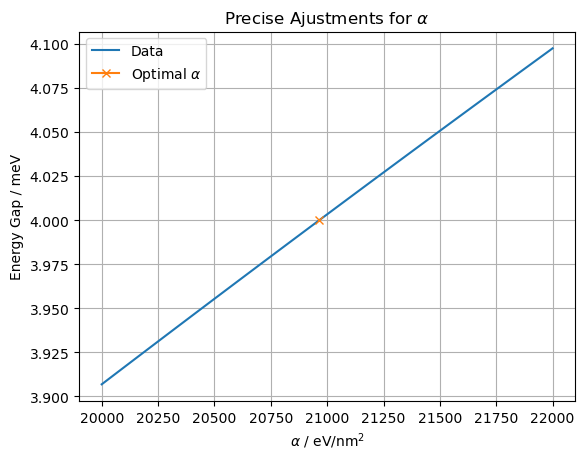

In [7]:
# Dialing it in

def space_from_alpha(alpha_range):
    
    # Parameters
    bounds = 40
    nodes = 800

    a = bounds*2E-9/nodes
    gap = []
    X=np.multiply(np.linspace(-bounds, bounds, nodes), 1E-9)  #nm

    t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
    on=2.0*t0*np.ones(nodes)
    off=-t0*np.ones(nodes-1)

    for al in alpha_range:
        
        U = al*1E9 * X**2
        H=np.diag(on+U)+np.diag(off,1)+np.diag(off,-1)

        W,V=np.linalg.eig(H)
        idx = W.argsort()[::1]   
        W = W[idx]
        V = V[:,idx]

        Energy_gap=W[1]-W[0]
        gap.append(Energy_gap)
    
    return gap

alpha_range = np.linspace(20000, 22000, 30)
y = np.multiply(space_from_alpha(alpha_range), 1E3)

def poly_2(x, A, B):
    y = A + B*(x)**(0.5)
    return y

popt, pcov = scipy.optimize.curve_fit(poly_2, alpha_range, y)

alpha_opt = ((4 - popt[0])/popt[1])**2
print('The best choice for alpha is ',alpha_opt//1)

plt.title('Precise Ajustments for $\\alpha$')
plt.plot(alpha_range, y, label='Data')
plt.grid()
plt.plot(alpha_opt, 4, marker='x', label='Optimal $\\alpha$')
plt.xlabel('$\\alpha$ / eV/nm$^2$')
plt.legend()
plt.ylabel('Energy Gap / meV')

**What is $\alpha$, physically?**

$\alpha$ is the 'strength' of the potential, without any separate applied electromagnetic field (i.e., Rabi Oscillations). In our Silicon QD device, we could possibly control $\alpha$ through our selection of semiconductor materials (i.e., silicon doping), or by varying the current running through our gates. The structure of the silicon lattice could also have a role to play, with manufacturing defects (think bad yields) absolutely being capable of ruining a QD. This would mainly be a logistical factor for mass production, which is a fair way in the future for silicon quantum computers.

**At what Temperatures would we expect this system to operate?**

To prevent decoherence (and transitions out of the ground states), thermal fluctuations would have to occur at below our energy level split of $4$ meV. Crudely:

$$
k_B T << 4 \text{meV} \qquad \implies T << 46 ^\circ K
$$

This is to cold for people, but for a Quantum computer this is downright toasty. Getting $T \approx << 46 ^\circ K$ would not require exotic and expensive cooling solutions, and is likely very achievable in a commercialised product. Researches have operated similar systems [at around $1^\circ K$](https://www.nature.com/articles/s41586-020-2171-6) (this is UNSW research), but this was using spin Qubits (although confined in a similar potential to what we are modelling).

We can refine our expected temperature when we do the double quantum dot, where we will require temperatures such that thermal fluctuations are well below the energy gap of our two degenerate ground states (i.e., our ground states will be very close in energy, on the order of tenths of millivolts). This would require:

$$k_B T << 0.1 \text{meV} \qquad \implies T << 1 K$$

Which is much more in line with existing devices and our expectations.

![1 K Qubit Diagram](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-020-2171-6/MediaObjects/41586_2020_2171_Fig1_HTML.png?as=webp)

>   The Spin Qubit that was operating above $1 \text{ K}$, from Yang, C.H., Leon, R.C.C., Hwang, J.C.C. et al

#### **ii)** But what of Computational Artifacts?

Its all well and good to just plug stuff into the model we have built as we have done so far, but we need to be sure we are not accidentally brushing over some computational artifacts. We need to check we aren't screwing things, and - importantly - that the value of our energy gap is converging with increasing resolution (and that we are plotting enough of the potential to avoid artificial confinement).

I have already been building in some ways of checking for computational artifacts. There is a variable in the code run so far called 'plot_check.' This plots the first $n$ wavefunction solutions against the potential and allows you to check for any discontinuities that might have arisen. I have set it to about 5, because this is the eigenstate range we care about, but feel free to ramp it and deliberately induce computational artifices (i.e., artificial confinement).

In order to check that we are plotting enough of the potential, our Eigenvalue plot should be linear for the important Eigenvalues (since we are looking at the lowest handful of energy levels, the first 5 or so eigenvalues should be linear). You can see this trend already on the initial plot, with the plot deviating from linear for the upper eigenvalues (that we aren't interesting in). This linear expectation comes from the analytical solution to the quantum harmonic oscillator.

Let’s plot the eigenvalues as we change the total plotted $x$ rage. We need to make sure we use a constant resolution throughout, so our test is valid (i.e., we are testing what we are trying to test for, and are not introducing any additional noise).



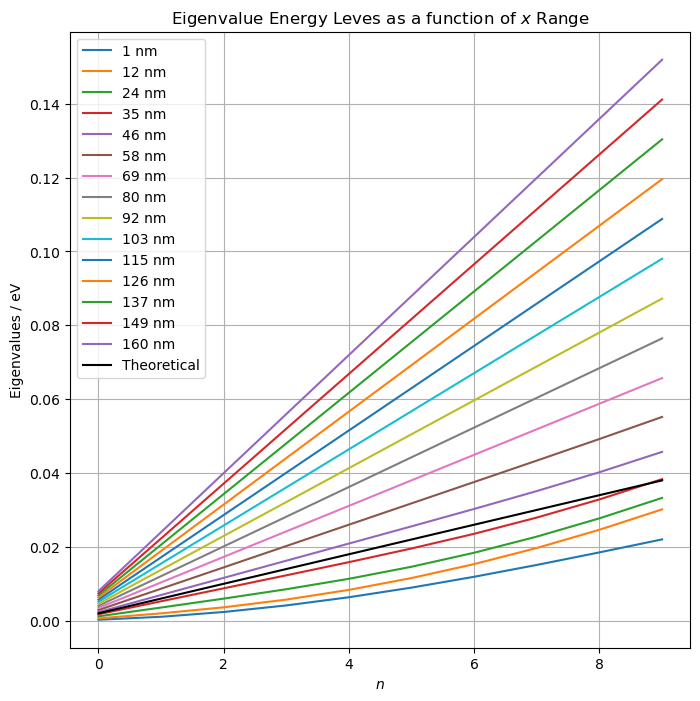

In [8]:
# Bounds and nodes for grid
plot_to = plot_to # Bounds in nm
resolution = 10 #nodes per nm
alpha = alpha # play if you want

iterations = 15

fig, ax1 = plt.subplots(1, figsize=(8,8))
boundary = np.linspace(1, 4*plot_to, iterations)

for i in boundary:

    nodes = 2*round(i)*resolution

    Bounds = np.multiply(i, [-1e-9, 1e-9])
    X = np.linspace(*Bounds, nodes)
    a = plot_to*2E-9/nodes

    U = (alpha*1E9)*(X)**2

    # Defining the Hamiltonian
    t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
    on=2.0*t0*np.ones(nodes)
    off=-t0*np.ones(nodes-1)

    H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

    # Solving the Matrix
    vals, vec = np.linalg.eigh(H)
    idx = vals.argsort()[::1]   
    vals = vals[idx]
    vec = vec[:,idx]

    ax1.plot(vals[:10], label='{} nm'.format(round(i)))

def theoretical(n):
    return (n + 0.5)*0.004

x = np.linspace(0,9,10)
ax1.plot(x, theoretical(x), color='black', label='Theoretical') 

ax1.grid()
ax1.set_xlabel('$n$')
ax1.set_ylabel('Eigenvalues / eV')
ax1.set_title('Eigenvalue Energy Leves as a function of $x$ Range')
ax1.legend()

This graph is not particularly helpful, but there is a lot to talk about here. The theoretical value is derived from $E_n = \left( n + \frac{1}{2} \right) \hbar \omega$, with $\omega = \frac{E_1 - E_0}{\hbar} = \frac{4 meV}{\hbar}$, from the analytic solution to the Quantum Harmonic Oscillator. This data was generated at a constant 'resolution' (in nodes/nm) to try and avoid any dependence on outside factors, but this does not appear to have been successful. This apparent divergence of the zero-point energy *could* have something to do with improper meshing, but this doesn't affect us for our values.

Regardless, we are looking for linearity in the early regions of the graph and general matching to the theoretical value. Our selected interval, $40$ nm, fulfills both these criteria very well, and from our plots of the wavefunctions from before, we can't see any discontinuities or deviations from the expected behaviour to indicate anything like artificial confinement in the lower eigenstates (although for the lower values in this graph, those curved ends do indicate artificial confinement).

Now let’s look for convergence of $\alpha$ as we increase our plotting resolution:

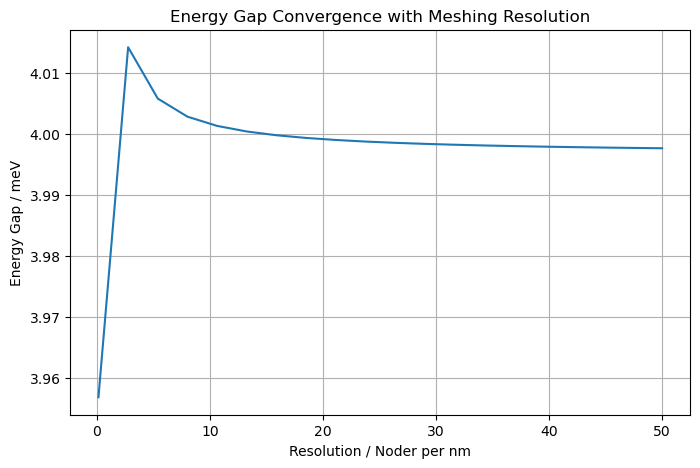

In [9]:
# Bounds and nodes for grid
plot_to = plot_to # Bounds in nm
nodes_max = 4000
alpha = alpha #20982.008208404975  # ev/nm^2

nodes_list = np.linspace(10, nodes_max, 20)
Bounds = np.multiply(plot_to, [-1e-9, 1e-9])

out = []

for i in nodes_list:
    i = round(i)
    
    X = np.linspace(*Bounds, i)
    a = plot_to*2E-9/i

    U = (alpha*1E9)*(X)**2

    # Defining the Hamiltonian
    t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
    on=2.0*t0*np.ones(i)
    off=-t0*np.ones(i-1)

    H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

    # Solving the Matrix
    vals, vec = np.linalg.eigh(H)
    idx = vals.argsort()[::1]   
    vals = vals[idx]
    vec = vec[:,idx]

    Energy_gap=vals[1]-vals[0]
    out.append(Energy_gap)
    
# Make Plots
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(nodes_list/(2*plot_to), np.multiply(out, 1E3))
ax1.set_xlabel('Resolution / Noder per nm')
ax1.set_ylabel('Energy Gap / meV')
ax1.set_title('Energy Gap Convergence with Meshing Resolution'); ax1.grid()

So, there is clearly convergence but law of diminishing returns kicks in quick. There are again, no signs of computational artifacts in the regions we are operating in, but clearly using $<250$ nodes (or 3 nodes per nm) leads to some improper meshing and poor results.

#### **iii)** Quantum Dots as Artificial Atoms

Descriptions of Quantum Dots as Artificial Atoms make a lot of sense. In both atoms and QDs, you have delocalised electric charges that are contained in an electrostatic potential (electrons with wavefunctions), and by adjusting their positioning you can allow them to interact with each other in various ways (analogous to chemical bonding).

When researching atoms, *most* people (obviously not radiochemists or nuclear physicists) care about how they behave electronically, and through the Born-Oppenheimer approximation we know that the electronic and nuclear wavefunctions can be approximately separated, so QDs can be electron clouds without a nucleus.

![polyacetylene](https://github.com/Sam-js2/PHYS3112_CompEssay/blob/main/eth_diagram.png?raw=true)

>   Polyacetylene Molecule

In some [UNSW-relevant research](https://newsroom.unsw.edu.au/news/science-tech/scientists-emulate-nature-quantum-leap-towards-computers-future), the team at Silicon Quantum Computing were able to use Quantum Dots very literally as artificial atoms to simulate the electronic behaviour of the molecule polyacetylene (basically a chain of $(C_2 H_2 )_n$ groups). In this experiment[2], splitting energies were about $3.85 \text{meV}$ and degenerate ground states across multiple QDs were achieved with energy differences of about $0.1 \text{meV}$ (which is what we will look at with the double quantum dot next). Temperatures here were between $10$ and $100 \text{mK}$, in line with our estimation from earlier.

![Ethene constructed from QDs](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-022-04706-0/MediaObjects/41586_2022_4706_Fig1_HTML.png?as=webp)

>   Ethene Construced from Silicon QDs using Phosphorus electron donors in doped silicon, from Kiczynski, M., Gorman, S.K., Geng, H. et al

For a sense of scale, lets plot our wavefunction from before against that of an analytic solution to the Hydrogen atom. I have applied a scaling factor so that these graphs look remotely comparable, so don't take the absolute values of the y axis as having any significant meaning.

Text(0.5, 1.0, 'Radial PDF for Hydrogen vs Half PDF for $\\Psi_1$')

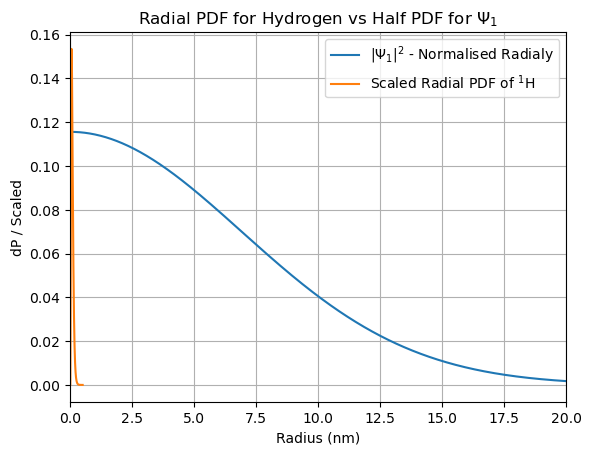

In [10]:
x = np.linspace(-plot_to, plot_to, len(Psi0))
y = Psi0/(0.5*scipy.integrate.simpson(Psi0, x))

x1 = np.linspace(0, 0.5, 400)
a0 = 0.0529
radial_pdf = (4/(a0**3))*(x1**2)*np.exp(-2*x1/a0)
y1 = 0.015*radial_pdf/scipy.integrate.simpson(radial_pdf, x1)

plt.plot(x, y, label='$|\Psi_1|^2$ - Normalised Radialy')
plt.plot(x1, y1, label='Scaled Radial PDF of $^1$H')


plt.xlabel('Radius (nm)')
plt.ylabel('dP / Scaled')

plt.grid()
plt.legend()
plt.xlim(0, 20)
plt.title('Radial PDF for Hydrogen vs Half PDF for $\Psi_1$')

Clearly there is a big difference in scale. The hydrogen Bohr radius, $a_0 = 0.0529 \text{ nm}$, fits into our electronic PDF (for $4 \text{ meV}$ splitting) about 400 times (not counting the tails).

For a silicon crystal structure with atoms evenly spaced every $0.543 \text{ nm}$, our ground state wavefunction ($\Psi$, not $|\Psi|^2$) would span about $110$ atoms.

### Part C: The Double Quantum Dot

Here we are introducing a second identical potential, with the value of $\alpha$ from before to produce $4 \text{ meV}$ splitting, spaced apart evenly about the zero of the axis by some separation constant in nanometres.

We’re approximating the total potential as the minimum of the two parabolic potentials, so
$$
V (x) =   \text{min } \left\{
\begin{array}{ll}
      \alpha \times \left( x - \frac{\text{seperation}}{2} \right)^2 \\
      \alpha \times \left( x + \frac{\text{seperation}}{2} \right)^2 \\
\end{array} 
\right.
$$

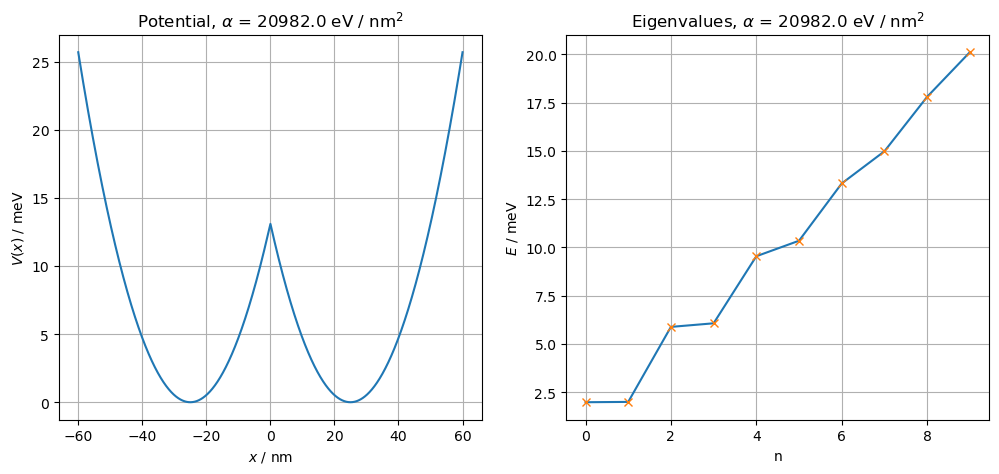

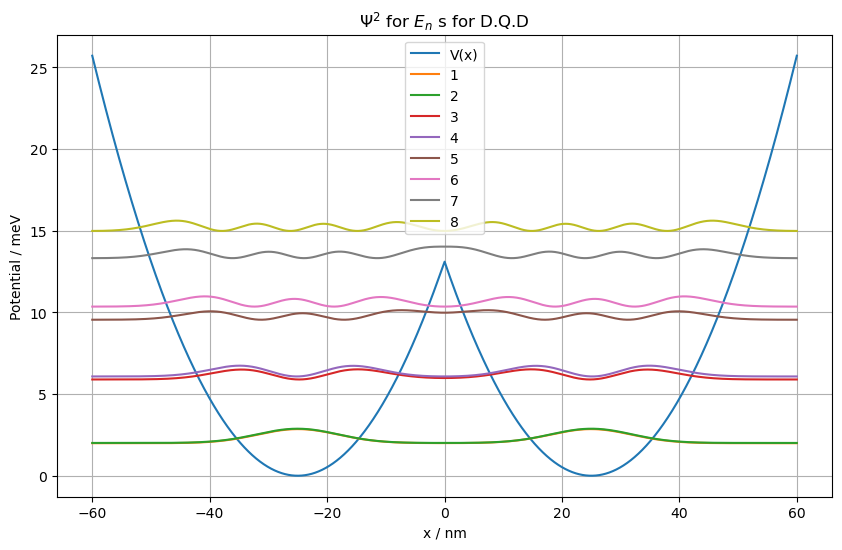

In [11]:
# Bounds and nodes for grid
plot_to = 60 # Bounds in nm
nodes = 4000
alpha = alpha # 20982.008208404975 optimal
seperation = 50 # seperation of quadratics in nm

# Plot solutions to Psi over potential to check for issues, set to eigenvalue or 0 for nothing, recomend setting to at least 2
plot_check = 8

Bounds = np.multiply(plot_to, [-1e-9, 1e-9])
X = np.linspace(*Bounds, nodes)
a = plot_to*2E-9/nodes

U1 = (alpha*1E9)*(X-seperation*0.5E-9)**2
U2 = (alpha*1E9)*(X+seperation*0.5E-9)**2
U = np.minimum(U1, U2)

# Defining the Hamiltonian
t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

# Solving the Matrix
vals, vec = np.linalg.eigh(H)
idx = vals.argsort()[::1]   
vals = vals[idx]
vec = vec[:,idx]

#print eigenvalues and energy gaps
Energy_gap=vals[1]-vals[0]
#print('Energy Gap =', Energy_gap*1E3,' meV')

# Make Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(X*1E9, U*1E3)
ax1.set_xlabel('$x$ / nm')
ax1.set_ylabel('$V (x)$ / meV')
ax1.set_title('Potential, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax1.grid()

ax2.plot(vals[:10]*1E3)
ax2.plot(vals[:10]*1E3, marker='x', linestyle='')
ax2.set_xlabel('n')
ax2.set_ylabel('$E$ / meV')
ax2.set_title('Eigenvalues, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax2.grid()

if plot_check != 0:
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(X*1E9, U*1E3, label='V(x)')
    for i in range(plot_check):
        plt.plot(X*1E9, (np.multiply(vec[:,i],vec[:,i]) + vals[i])*1E3, label='{}'.format(i+1))
    plt.grid()
    plt.ylabel('Potential / meV')
    plt.xlabel('x / nm')
    plt.legend()
    plt.title('$\Psi^2$ for $E_n$ s for D.Q.D')
    plt.show()

Now lets explore (and animate) what happens when we change the dot-to-dot seperation.

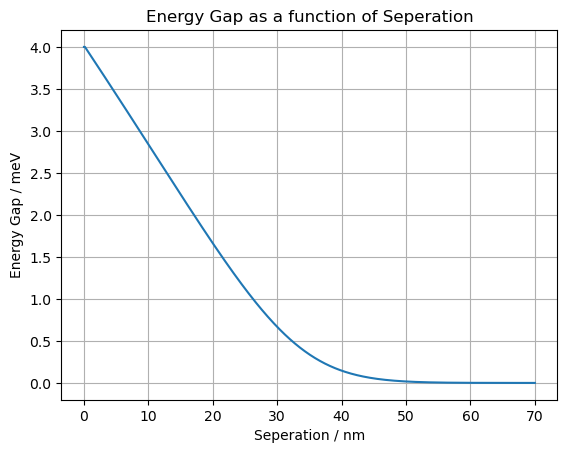

(None, None)

In [12]:
max_offset = 70
trials = 450
nodes = 1000

offset_range = np.linspace(0, max_offset, trials)

a = plot_to*2E-9/nodes
X = np.linspace(-plot_to*1E-9, plot_to*1E-9, nodes)

t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

gaps = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
u, = ax1.plot([], label='$V(x)$')
psi_12, = ax1.plot([], label='$\Psi_1|^2$')
psi_22, = ax1.plot([], label='$|\Psi_2|^2$')

ax1.set_xlabel('$x$ / nm')
ax1.set_ylabel('Potential / eV')
ax1.set_xlim(-plot_to, plot_to)
ax1.set_ylim(0, 30)
ax1.set_title('Effect of Seperation on System')
ax1.legend(loc=9)
ax1.grid()

psi_1, = ax2.plot([], label='Re $\Psi_1$', color='orange')
psi_2, = ax2.plot([], label='Re $\Psi_2$', color='green')

ax2.grid();
ax2.set_ylabel('$\Psi$')
ax2.set_xlabel('x / nm')
ax2.legend()
ax2.set_title('Re $\Psi$ for $E_n$ s for Seperation = {} nm'.format(seperation//1))
ax2.set_yticklabels([])
ax2.set_xlim(-plot_to, plot_to)
ax2.set_ylim(-0.10, 0.10)


def animate(i):
    seperation = offset_range[i]
    
    U1 = (alpha*1E9)*(X-seperation*0.5E-9)**2
    U2 = (alpha*1E9)*(X+seperation*0.5E-9)**2
    U = np.minimum(U1, U2)

    H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

    # Solving the Matrix
    vals, vec = np.linalg.eigh(H)
    idx = vals.argsort()[::1]   
    vals = vals[idx]
    vec = vec[:,idx]
    
    Energy_gap=vals[1]-vals[0]
    gaps.append(Energy_gap)
    
    u.set_data(X*1E9, U*1E3)
    psi_1.set_data(X*1E9, (vec[:,0]))
    psi_2.set_data(X*1E9, (vec[:,1]))
    psi_12.set_data(X*1E9, (np.multiply(vec[:,0],vec[:,0]) + vals[0])*1E3)
    psi_22.set_data(X*1E9, (np.multiply(vec[:,1],vec[:,1]) + vals[1])*1E3)
    
    plt.suptitle('Seperation = {} nm'.format(round(seperation,2)))

plt.tight_layout()

anim = FuncAnimation(fig, animate, frames=trials, interval=30)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
    
fig2 = plt.figure()
plt.plot(offset_range, np.multiply(gaps[:-1], 1E3))
plt.xlabel('Seperation / nm')
plt.ylabel('Energy Gap / meV')
plt.title('Energy Gap as a function of Seperation')
plt.grid(), plt.show()

We can see two distinct 'modes' of interaction. When the dots are sufficiently dispersed, the wavefunctions are degenerate, and when they are too close, there is no degeneracy. This also means that the seperation of the QDs functions like $E$ from our idealised two-state system.

For our quantum computing system, we want to finely control that degeneracy so we can bias one readout at once point in times. We want wavefunctions that have very similar energy levels but that are localised in different areas (into different QDs). This is to say, we want two Wavefunctions that are:

a) Degenerate, they should have the same (or very close) eigenvalues, and,
b) Are localised in different halves of double QD potential.

Clearly, we want one of the weaker interactions to ensure the energy levels are close to degenerate, but we aren't getting the different localisation that we want just by changing the separation. To try and solve this, we will introduce another parameter to our potential:

$$
V (x) =  F x +  \text{min } \left\{
\begin{array}{ll}
      \alpha \times \left( x - \frac{\text{seperation}}{2} \right)^2 \\
      \alpha \times \left( x + \frac{\text{seperation}}{2} \right)^2 \\
\end{array} 
\right.
$$

Where $F$ is some applied field. The units here are arbitrary, but you would need to apply an eV to volts conversion and multiply by the charge of the electrons to get some reasonable units (they would end up on the order of $\text{meV}$). Let’s plot this statically for a select potential, and then watch it evolve over a range of $F$.

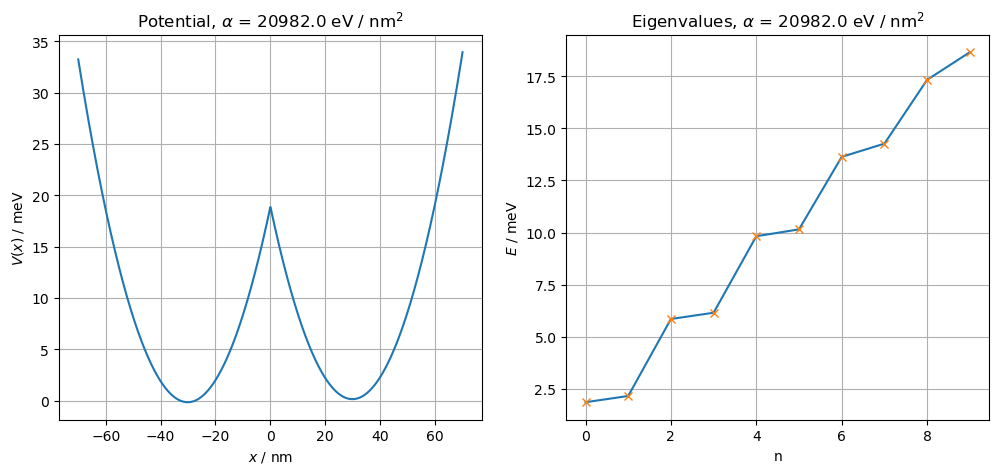

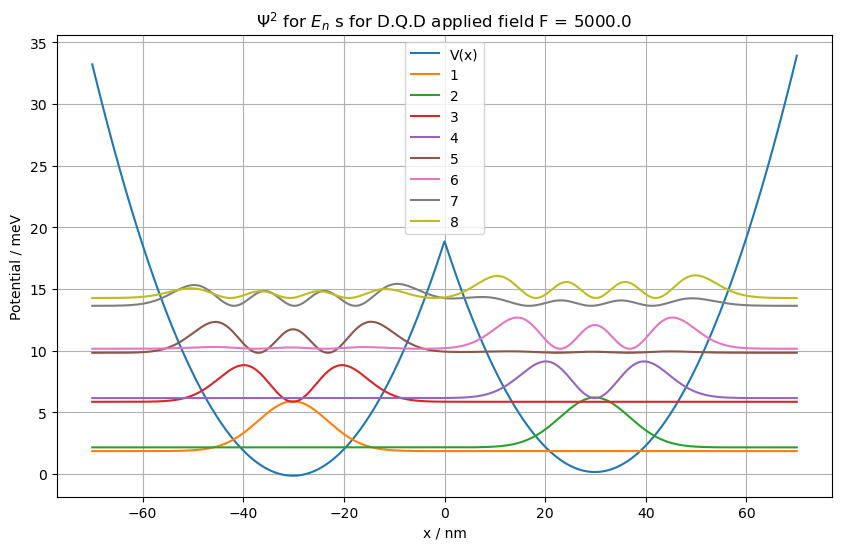

In [13]:
# DQD with electric field

# Bounds and nodes for grid
plot_to = 70 # Bounds in nm
nodes = 1200
alpha = alpha # 20982.008208404975 optimal
seperation = 60 # seperation of quadratics in nm
F =  5e3 #this is just the electric force per nm (i.e., Potential = F x), needs factors of q 

# Plot solutions to Psi over potential to check for issues, set to eigenvalue or 0 for nothing, recomend setting to at least 2
plot_check = 8

Bounds = np.multiply(plot_to, [-1e-9, 1e-9])
X = np.linspace(*Bounds, nodes)
a = plot_to*2E-9/nodes

U0 = np.multiply(F, X)
U1 = (alpha*1E9)*(X-seperation*0.5E-9)**2
U2 = (alpha*1E9)*(X+seperation*0.5E-9)**2
U = np.add(np.minimum(U1, U2), U0)

# Defining the Hamiltonian
t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

# Solving the Matrix
vals, vec = np.linalg.eigh(H)
idx = vals.argsort()[::1]   
vals = vals[idx]
vec = vec[:,idx]

#print eigenvalues and energy gaps
Energy_gap=vals[1]-vals[0]
#print('Energy Gap =', Energy_gap*1E3,' meV')

# Make Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(X*1E9, U*1E3)
ax1.set_xlabel('$x$ / nm')
ax1.set_ylabel('$V (x)$ / meV')
ax1.set_title('Potential, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax1.grid()

ax2.plot(vals[:10]*1E3)
ax2.plot(vals[:10]*1E3, marker='x', linestyle='')
ax2.set_xlabel('n')
ax2.set_ylabel('$E$ / meV')
ax2.set_title('Eigenvalues, $\\alpha$ = {} eV / nm$^2$'.format(alpha//1)); ax2.grid()

if plot_check != 0:
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(X*1E9, U*1E3, label='V(x)')
    for i in range(plot_check):
        plt.plot(X*1E9, (np.multiply(vec[:,i],vec[:,i]) + vals[i])*1E3, label='{}'.format(i+1))
    plt.grid()
    plt.ylabel('Potential / meV')
    plt.xlabel('x / nm')
    plt.legend()
    plt.title('$\Psi^2$ for $E_n$ s for D.Q.D applied field F = {}'.format(F))
    plt.show()

Clearly we have ticked both of those boxes with this particular selection of $F$. Lets see how the first two wavefunction change with a variable $F$, accross positive and negative values.

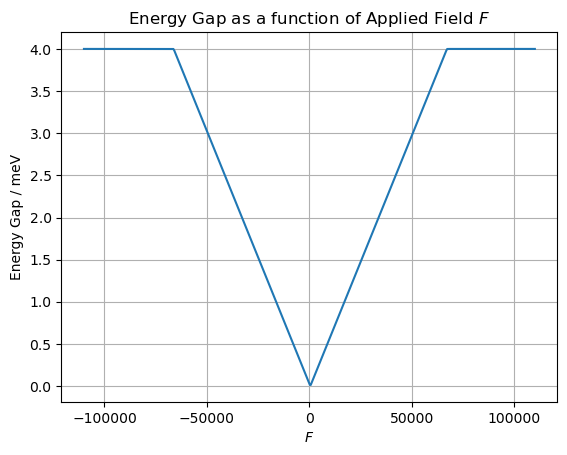

(None, None)

In [14]:
from matplotlib.animation import FuncAnimation
from IPython import display

F_min = -110000 #this is just the electric force per nm (i.e., Potential = F x), needs factors of q 
F_max =  110000
trials = 500
nodes = 1000

F_list = np.linspace(F_min, F_max, trials)
a = plot_to*2E-9/nodes

X = np.linspace(-plot_to*1E-9, plot_to*1E-9, nodes)

U1 = (alpha*1E9)*(X-seperation*0.5E-9)**2
U2 = (alpha*1E9)*(X+seperation*0.5E-9)**2
Un = np.minimum(U1, U2)

t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

gaps = []

fig, axs = plt.subplots(figsize=(10,6))
u, = axs.plot([], label='$V(x)$')
psi_1, = axs.plot([], label='$|\Psi_1|^2$')
psi_2, = axs.plot([], label='$|\Psi_2|^2$')

axs.set_xlabel('$x$ / nm')
axs.set_ylabel('Potential / eV')
plt.xlim(-plot_to, plot_to)
plt.ylim(-4, 30)
axs.set_title('Effect of Changing Field on System')
axs.legend(loc=9)
axs.grid()

F_text = plt.text(-57, 28, 'x')

plt.tight_layout()  

def animate(i):
    
    F = F_list[i]
             
    U0 = np.multiply(F, X)
    U = np.add(Un, U0)

    H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

    vals, vec = np.linalg.eigh(H)
    idx = vals.argsort()[::1]   
    vals = vals[idx]
    vec = vec[:,idx]

    Energy_gap=vals[1]-vals[0]
    gaps.append(Energy_gap)

    u.set_data(X*1E9, U*1E3)
    psi_1.set_data(X*1E9, (np.multiply(vec[:,0],vec[:,0]) + vals[0])*1E3)
    psi_2.set_data(X*1E9, (np.multiply(vec[:,1],vec[:,1]) + vals[1])*1E3)
    
    F_text.set_text('Field Strength $F = $ {} $ \\times 10^3 $'.format(round(F*1E-3, 1)))
    

anim = FuncAnimation(fig, animate, frames=trials, interval=30)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
    
fig2 = plt.figure()
plt.plot(F_list, np.multiply(gaps[:-1], 1E3))
plt.xlabel('$F$')
plt.ylabel('Energy Gap / meV')
plt.title('Energy Gap as a function of Applied Field $F$')
plt.grid(), plt.show()

**Look Familiar?** This graph for the energy gap as a function of $F$ is incredibly similar to our graph for $t$ for our formal two-state system. We can conclude that $F$ is, like $t$, a detuning bias. This bias controls the localisation of the electron between the two quantum dots. 

For our Quantum Computer, we want our eigenstates somewhere in that trench, where the desired localisation is achieved. Outside of the trench, our wavefunctions both move into the same parabolic space. Moving too close to the edges of the trench means that the energy gap between our wavefunctions of interest and the others is much lower, raising the chances of decoherence. 

As said previously, the units for $F$ here are arbitrary. You would need several conversion factors to get them into something usable, and if you did, we would expect them to be on the order of millivolts. 

### Part D: Rabi Oscillations & Time Evolution

Here we will redefine $\Psi_1$ and $\Psi_2$ to be the wavefunction localised in the left and right potential lobes respectively, whereas before we were defining them simply by the value of their corresponding Eigenvalue. This will give us some ability to map our readouts of probabilities.

We change the potential to include a time dependant potential:

$$
V (x) =  F x \cos \left( \omega t \right) +  \text{min } \left\{
\begin{array}{ll}
      \alpha \times \left( x - \frac{\text{seperation}}{2} \right)^2 \\
      \alpha \times \left( x + \frac{\text{seperation}}{2} \right)^2 \\
\end{array} 
\right.
$$

This means we now need to solve the time dependant Schrodinger Equation. Luckily, we can use separation of variables to break the wavefunction into spatial and time dependant components:

$$
\Psi = \psi(x) \cdot \psi(t)
$$

The solution at each moment in time will be the product of the spatial solution and the time dependant Schrodinger's equation, which has the following known form:

$$
\psi(t) = e^{-i \omega t}
$$

This is (by inspection) just some complex phasor (ie., a complex number with modulus 1). This means that none of our observables are changed with $t$ (apart from changes from the changing potential), but the wavefunction, $\Psi$, will 'rotate' in and out of the complex domain*.

So our solution for $\psi$ will be a spatial component, $\psi(x, t)$ - there is some $t$ dependence here because $V(x,t)$, and a time dependant component $\psi(t)$, which doesn't impact our observables because they are all real.

The Rabi oscillations just do what our previous animation was doing, but cyclically with some maximum strength, $F$. This means that, with time, one eigenstate will become preferable, and this preferred eigenstate will change periodically with $\omega$. In practice, Rabi oscillations (and broadly Rabi Experiments) can confirm that a Qubit is functioning as intended.

.* You can view this rotation on the following animation by changing plot_psi to false, this will plot $\text{Re } \Psi$ instead of $|\Psi|^2$

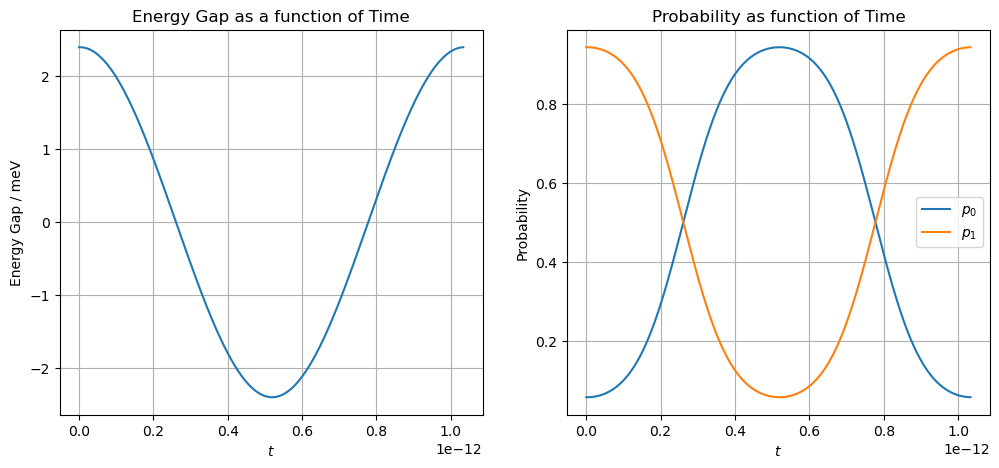

In [15]:
# If True, plots the real part of Psi rather than |Psi|^2. This shows the parts of the schrodingers equation from the time dependant part
# Everything still works identically with time dependance, vindication!
plot_psi = False
# there is a scale factor here that dissapears when you take the square 

trials = 400
nodes = 1000

F = 40000
omega = 0.004*q/hbar

t_list = np.linspace(0, 2*np.pi/omega, trials)
a = plot_to*2E-9/nodes
X = np.linspace(-plot_to*1E-9, plot_to*1E-9, nodes)

U1 = (alpha*1E9)*(X-seperation*0.5E-9)**2
U2 = (alpha*1E9)*(X+seperation*0.5E-9)**2
Un = np.minimum(U1, U2)

t0=(hbar*hbar)/(2*m*a*a)/q #divide by q to convert to eV
on=2.0*t0*np.ones(nodes)
off=-t0*np.ones(nodes-1)

gaps = []; p1s = []

fig, axs = plt.subplots(figsize=(10,6))
u, = axs.plot([], label='$V(x)$')

if plot_psi == False:
    psi_1, = axs.plot([], label='$|\Psi_1|^2$')
    psi_2, = axs.plot([], label='$|\Psi_2|^2$')
else:
    psi_1, = axs.plot([], label='$Re(\Psi_1)$')
    psi_2, = axs.plot([], label='$Re(\Psi_2)$')

axs.set_xlabel('$x$ / nm')
axs.set_ylabel('Potential / eV')
plt.xlim(-plot_to, plot_to)
plt.ylim(-4, 30)
axs.set_title('Effect of Rabi Oscillations on System')
axs.legend(loc=9)
plt.tight_layout()
axs.grid()             

def animate(i):
    
    t = t_list[i]
    U0 = np.multiply(F*np.cos(omega*t), X)
    U = np.add(Un, U0)

    H = np.diag(on+U) + np.diag(off,1) + np.diag(off,-1)

    vals, vec = np.linalg.eigh(H)
    idx = vals.argsort()[::1]   
    vals = vals[idx]
    vec = np.multiply(vec[:,idx], 1)#psi_t)
    
    if plot_psi == False:
        psi1 = (np.multiply(vec[:,0],vec[:,0]) + vals[0])*1E3
        psi2 = (np.multiply(vec[:,1],vec[:,1]) + vals[1])*1E3
    else:
        psi_t = np.exp(-1j*omega*t)
        psi1 = (np.multiply(0.07*vec[:,0],psi_t) + vals[0])*1E3
        psi2 = (np.multiply(0.07*vec[:,1],psi_t) + vals[1])*1E3
    
    if psi2.argmax() >= psi1.argmax():
        psi_1.set_data(X*1E9, psi1)
        psi_2.set_data(X*1E9, psi2)
        Energy_gap=vals[1]-vals[0]
        
        p1 = vals[0]**2/(vals[1]**2 + vals[0]**2)
        p1s.append(p1)
    else:
        psi_1.set_data(X*1E9, psi2)
        psi_2.set_data(X*1E9, psi1)
        Energy_gap=vals[0]-vals[1]
        
        p1 = vals[1]**2/(vals[1]**2 + vals[0]**2)
        p1s.append(p1)
    
    gaps.append(Energy_gap)
    u.set_data(X*1E9, U*1E3)

anim = FuncAnimation(fig, animate, frames=trials, interval=30)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()
    
fig2, (ax5, ax6) = plt.subplots(1, 2, figsize=(12,5))
ax5.plot(t_list, np.multiply(gaps[:-1], 1E3))
ax5.set_xlabel('$t$')
ax5.set_ylabel('Energy Gap / meV')
ax5.set_title('Energy Gap as a function of Time')
ax5.grid()

ax6.plot(t_list, p1s[:-1], label='$p_0$')
ax6.plot(t_list, np.subtract(1, p1s)[:-1], label='$p_1$')
ax6.set_xlabel('$t$')
ax6.set_ylabel('Probability')
ax6.set_title('Probability as function of Time')
ax6.legend()
ax6.grid()

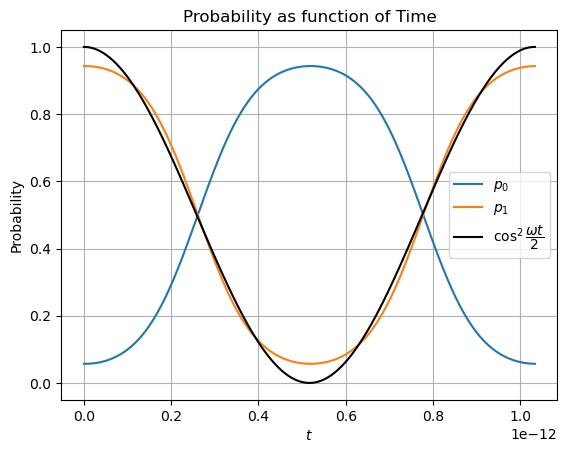

In [16]:
fig2, ax6 = plt.subplots()

ax6.plot(t_list, p1s[:-1], label='$p_0$')
ax6.plot(t_list, np.subtract(1, p1s)[:-1], label='$p_1$')
ax6.set_xlabel('$t$')
ax6.set_ylabel('Probability')
ax6.set_title('Probability as function of Time')
ax6.plot(t_list, np.cos(0.5*omega*t_list)**2, label='$\cos^2 \dfrac{\omega t}{2}$', color='black')

ax6.legend()
ax6.grid()

This very closely matches the theoretical $\cos^2 \left( \frac{\omega_R t}{2} \right)$ model, but there is clearly a dampening term here from our suboptimal selection of $F$. This matches with our theoretical two-state system nicely, where our selection of $t$ caused straining and squishing of the probability graph (and remember, our selection of $F$ is analogous to $t$).

Choosing a better value for $F$, such that we are teetering on the edge of the trench from before alleviates these issues, but pushing beyond that and we get some dampening, where the functions 'squish up' against the ceiling and floor. I encourage you to play with it yourself.

### Part E: Into the Third (but really second) Dimension - Extension

So far, we have been solving the Schrodinger's in one dimension and plotting our solutions against one dimension of potential.

Now, let’s move into the two-dimensional Schrodinger’s equation against another dimension of potential (for 3 dimensions in total). Recall the more general Schrodinger's Equation:

$$
- \frac{\hbar^2}{2 m^*} \nabla^2 \psi(x) + V \psi  = E \psi
$$

Let’s start by defining our double QD potential in two dimensions. We will add a constant magnetic field term as before to cause that degenerate localisation split. This potential can be described as follows:

$$
V(x,y) = F x +  \alpha \times \text{min } \left\{
\begin{array}{ll}
       \left( x - \frac{\text{seperation}}{2} \right)^2 + y^2 \\
       \left( x + \frac{\text{seperation}}{2} \right)^2 + y^2\\
\end{array} 
\right.
$$

This seems a little too straightforward, but in polar coordinates $v = \alpha r^2$, so the squares all cancel out nicely. You can do the maths by hand if you want.

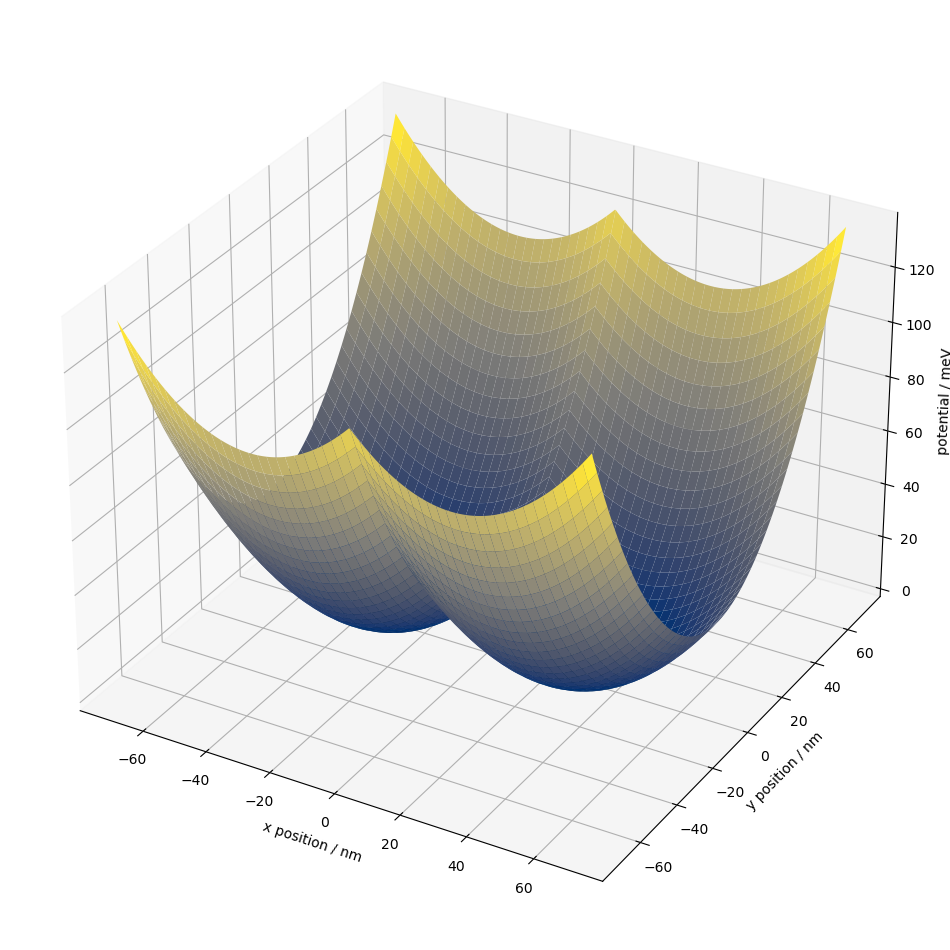

In [17]:
plot_to = 70
seperation = 60
# this will solve a massive matrix, scaling is really bad
nodes_1D = 500
alpha = 20982.008208404975
F =  5e3

fig = plt.figure(figsize = (12,14))
ax = plt.axes(projection='3d')

x = np.multiply(np.linspace(-plot_to, plot_to, nodes_1D), 1E-9)
y = np.multiply(np.linspace(-plot_to, plot_to, nodes_1D), 1E-9)

X, Y = np.meshgrid(x, y)
Z1 = (alpha*1E9)*((X - seperation*1E-9/2)**2 + (Y)**2)
Z2 = (alpha*1E9)*((X + seperation*1E-9/2)**2 + (Y)**2)
Z3 = F * X
V = np.add(np.minimum(Z1, Z2), Z3)

surf = ax.plot_surface(X*1E9, Y*1E9, V*1E3, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x position / nm')
ax.set_ylabel('y position / nm')
ax.set_zlabel('potential / meV')

#fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

In [18]:
# This just animates a rotation around the above potential,
# its here but its not very useful. Keep False.
Run = False
def animate(i):
    ax.view_init(elev=10, azim=4*i)
if Run == True:
    anim = FuncAnimation(fig, animate, frames=100, interval=80)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In order to solve this, we are going to need the Kronecker (tensor) Product. The following equation is useful:

$$
\left[ -\frac{\hbar^2}{2m^*} \left( D \otimes D \right) + V I \right] \Psi = E \Psi
$$

Where $D$ is defined to make our lives easer,

$$
D = \begin{bmatrix}
-2     & 1       & 0       & \cdots  & \cdots& 0 \\
1      & -2      & 1       &         &       & \\
0      &  1      &-2       & \ddots  &       & \\
\vdots &         & \ddots  & \ddots  & \ddots &  0 \\
\vdots &         &         & \ddots  &-2 & 1 \\
0      &         &         & 0       & 1    & -2 \\
\end{bmatrix} \qquad N \times N
$$

We are just going to ignore $m$, $\hbar$ exe, and we will get an answer that is $\propto$ but not $=$, which is fine as this won't impact our observables, which need to be normalised anyway.

In [19]:
# We will only find this many eigenstates - increase at YOUR peril (long time to run)
k = 24

diag = np.ones([nodes_1D])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), nodes_1D, nodes_1D)
T = -0.5 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(nodes_1D**2), (0))
H = T+U

eigenvalues, eigenvectors = eigsh(H, k, which='SM')

We can plot the $|\Psi_n|^2$ s for different eigenvalues $n$. There is no easy way to get the energies here, but we are using the same parameters as our static, fixed field (i.e., no Rabi Oscillations) plot, so you can extrapolate some information from that.

*Two-digit $n$ s brek F strings with subscript when in math mode, apparently, so $|\Psi_1 1|^2 = |\Psi_{11}|^2$ for the next graph.*

In [20]:
def get_e(n):
    return eigenvectors.T[n].reshape((nodes_1D,nodes_1D))

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-plot_to, plot_to)
ax.set_ylim(-plot_to, plot_to)
ax.set_xlabel('$x$ / nm')
ax.set_ylabel('$y$ / nm')

label = ax.text(-5, round(0.8*plot_to), '', color='white', size=16)

def animate(i):
    ax.pcolormesh(X*1E9, Y*1E9, get_e(i)**2, cmap='nipy_spectral')
    label.set_text('$|\Psi_{}|^2$'.format(i+1))

plt.tight_layout()

anim = FuncAnimation(fig, animate, frames=k, interval=1200)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

We can clearly see that we preserve the independent localisation of the Eigenstates within the potential when we move into two dimensions.

The higher order Eigenstates are shown here because they are interesting. Clearly our selection of the $V = F x$ terms are suboptimal for the two 'halves' to appear so different. It’s interesting to compare these to some similar wavefunctions we might know, i.e., Hydrogen or a 2D well, there are some common patterns.

There appear to be a lot of degenerate eigenstates, likely because of symmetries. There also appears not to be very much interaction between the two QD sites, possibly a smaller separation distance is needed in three dimensions.

Let’s plot the Eigenvalues to investigate this further:

Text(0, 0.5, 'Energy / Arb. Units')

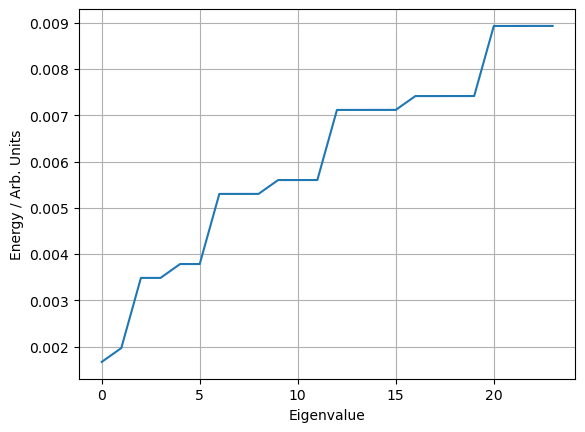

In [21]:
plt.plot(eigenvalues)
plt.grid()
plt.xlabel('Eigenvalue')
plt.ylabel('Energy / Arb. Units')

We can  see a very slight energy gap between the first two eigenstates, states we know are localised in the different QDs. This behaviour matches our intentions coming from our toy 1D, 2QD system. I highly recommend changing the code to cause some more mixing of the wavefunctions (i.e., decrease separation).

Also yes, there are clearly a lot of degenerate states. This would appear to suggest the existence of additional quantum numbers, beyond just the $n$ required of the analytic solution to the 1D QHM, we could also have a crack at guessing the degeneracy rules for this new quantum number. Let’s compare these wavefunctions to solutions for the Hydrogen-Like Atom, where the quantum number $\ell$ increases *across* the graph and quantum number *n* increases down the cells.

![Hydrogen Like Atom SE Solutions](https://upload.wikimedia.org/wikipedia/commons/c/cf/HAtomOrbitals.png)

>   PDF Solutions for the Hydrogen Like Atom, FlorianMarquardt through Wikipedia

Similar behaviour, but not quite the same. Lets look at a better system, and infinite two-dimensional, circular well. Interestingly, this system has an analyticl solution in **Bessel Functions** (flashbacks to MATH2221). These are well known functions, amd they are even tabulated in the scipy package. Lets plot the first few Bessel Functions squared, in a similar manner to our wavefunction PDFs.

In [22]:
resolution = 1000
# The parameters we are to plot, the order is not of any deliberate significance
array = np.array([[0,1],[0,2],[1,1],[1,2],[1,3],[2,1],[2,2],[2,3],[3,1],[3,2],[3,3]])

def drumhead_height(n, k, distance, angle, t):
   kth_zero = special.jn_zeros(n, k)[-1]
   return np.cos(t) * np.cos(n*angle) * special.jn(n, distance*kth_zero)

theta = np.r_[0:2*np.pi:(1j*resolution)]
radius = np.r_[0:1:(1j*resolution)]

x = np.array([r * np.cos(theta) for r in radius])
y = np.array([r * np.sin(theta) for r in radius])

def animate(i):
   data = array[i]
   z = np.power(np.abs(np.array([drumhead_height(*data, r, theta, 0.5) for r in radius])),2)
   ax.pcolormesh(x, y, z, cmap='nipy_spectral')


fig, ax = plt.subplots(figsize=(6,6))
ax.axis('off')
plt.tight_layout()

anim = FuncAnimation(fig, animate, frames=len(array), interval=1200)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

C:\Users\samsh\AppData\Local\Temp\ipykernel_4044\2084003824.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(x, y, z, cmap='nipy_spectral')


Doing it on python is all well and good, but it can be a bit of a pain. A better version of exactly this can be found [on reddit, here](https://old.reddit.com/r/Physics/comments/mfov6m/first_70_states_of_a_particle_trapped_in_a/).

Some of those wavefunctions look similar, some don't, but we are clearly on the right track. A lot of the *behaviours* match quite well. We might next want to try comparing this to an infinite *square* well in two-dimensions, but that will have to be some other time.

## Conclusion

Lets quickley rehash what we have done so far. 

We started by analysing the general two-state system analytically. Then we used a parabolic potential as a single QD to engineer a specific energy gap between the ground and first excited eigenstate. We observed how our selection of $\alpha$ changed the energy gap, and looked for computational artifacts by investigating the convergence of our measurables.

We then moved to a double QD, and played with the centre-to-centre dot separation to control the energy splitting of the ground eigenstates ($E$, from our ideal two-state system). We introduced a static electric field to give us two degenerate (or very nearly degenerate) Eigenstates that had different localisations (in each of the parabolic potentials). This applied electric field behaved as a detuning bias ($t$, from our ideal two-state system).

We replaced this fixed electric field with a time dependant potential to observe Rabi Oscillations. We recorded and plotted the probability of measuring a $\ket{1}$ or $\ket{0}$ as a function of time, and compared this to our predictions from the idealised two-state system.

Moving back to the fixed field, we move up a dimension and solved the Schrodinger's equation numerically with an $x$ and $y$ component. We compared the behaviour of this solution to the 2D case, and also to other, higher dimensional Quantum systems, and noticed patters regarding symmetry, degeneracy, and quantum numbers (i.e., $\ell$ in the Hydrogen solution).

Overall, our toy system has evolved into a suprisingly good, simulated implimentation of an ideal two-state system. A lot of background knowlege about quantum computation was gained, and a greater familiarity with the concepts discussion in lectures was developed by applying them in context.

### Future Improvements & A Brief Reflection

On the coding side, future improvements could see the use of GPU acceleration to solve much larger matrices using the Python Torch library. The code could most certainly be made more compact throug the use of functions, but I felt this would have sacrificed too much in terms of flexibility and interactivity.

I feel that the use of animations really enhanced the interactivity of this notebook, and did a much better job of showing what we are changing with our parameters than any single static graph or block of text ever could. I could have animated the $\alpha$ changes, but this would be by far the most *boring* animation (unless I was to use it to explore computational artifacts).

I tried not to artifically use seperations (i.e, randomly "ii) computational artificats ) and to introduce topics organically (hey! this graph looks familiar). There is a good chance this will be read as  not clearly addressing the points in the task description, and that is probably fair.

I assume the final submission is a PDF only for the reasons of record keeping and TurnitIn (chatGPT code detection?), so I have really leant in to the Jupyter format. This is an interactive format, it should be used interactively.

Sorry if cells took ages to run.

---

### References 

3D Plotting — Python Numerical Methods (no date). Available at: https://pythonnumericalmethods.berkeley.edu/notebooks/chapter12.02-3D-Plotting.html (Accessed: 23 April 2023).

‘Hydrogen atom’ (2023) Wikipedia. Available at: https://en.wikipedia.org/w/index.php?title=Hydrogen_atom&oldid=1149075574 (Accessed: 23 April 2023).

Kiczynski, M. et al. (2022) ‘Engineering topological states in atom-based semiconductor quantum dots’, Nature, 606(7915), pp. 694–699. Available at: https://doi.org/10.1038/s41586-022-04706-0.

Ono, K., Mori, T. and Moriyama, S. (2019) ‘High-temperature operation of a silicon qubit’, Scientific Reports, 9(1), p. 469. Available at: https://doi.org/10.1038/s41598-018-36476-z.

Polson, L. (2023) ‘Youtube Channel Repository’. Available at: https://github.com/lukepolson/youtube_channel/blob/4457c3049981dda6d0fc52f5061eb9ea87f38fc7/Python%20Metaphysics%20Series/vid6.ipynb (Accessed: 23 April 2023).

‘Quantum harmonic oscillator’ (2023) Wikipedia. Available at: https://en.wikipedia.org/w/index.php?title=Quantum_harmonic_oscillator&oldid=1151104095 (Accessed: 23 April 2023).

‘Rabi cycle’ (2023) Wikipedia. Available at: https://en.wikipedia.org/w/index.php?title=Rabi_cycle&oldid=1149687958 (Accessed: 23 April 2023).

rahman,  rajib (2023) ‘schrodinger_1D 2’.

Robinett, R.W. (2003) ‘Quantum mechanics of the two-dimensional circular billiard plus baffle system and half-integral angular momentum’. arXiv. Available at: https://doi.org/10.48550/arXiv.quant-ph/0307035.

Veldhorst, M. et al. (2015) ‘A two-qubit logic gate in silicon’, Nature, 526(7573), pp. 410–414. Available at: https://doi.org/10.1038/nature15263.

Where is the Rabi oscillation? – QuTech Blog (no date). Available at: https://blog.qutech.nl/2021/07/01/where-is-the-rabi-oscillation/ (Accessed: 23 April 2023).

Yang, C.H. et al. (2020) ‘Operation of a silicon quantum processor unit cell above one kelvin’, Nature, 580(7803), pp. 350–354. Available at: https://doi.org/10.1038/s41586-020-2171-6.

z8826307 (2022) Scientists emulate nature in quantum leap towards computers of the future, UNSW Newsroom. Available at: https://newsroom.unsw.edu.au/news/science-tech/scientists-emulate-nature-quantum-leap-towards-computers-future (Accessed: 23 April 2023).

